### Read in overlaid data

In [1]:
import pandas as pd
df = pd.read_parquet('./material/soc.snr_overlaid_v20250301.pq')
print(df.shape)

(122436, 468)


### Mask out other land covers

In [2]:
nan_stats = df.groupby('ref')['lc_survey'].agg(
    total_count='count',
    nan_count=lambda x: x.isna().sum(),
    total_rows=lambda x: x.shape[0]
)

nan_stats['nan_percentage'] = 100 * nan_stats['nan_count'] / nan_stats['total_rows']
print(nan_stats)
keep_ref = nan_stats.loc[nan_stats['nan_percentage']<10].index.tolist()

                total_count  nan_count  total_rows  nan_percentage
ref                                                               
Czech                   728          0         728        0.000000
GLanCE                  911          0         911        0.000000
LUCAS                 62577          1       62578        0.001598
MarSOC                  103          0         103        0.000000
NatbodDS                  0       4813        4813      100.000000
ParcelasCOS            1578          0        1578        0.000000
ParcelasINES          22161          0       22161        0.000000
Pedološka               217          8         225        3.555556
SoDaH                    72        303         375       80.800000
basque                  826          0         826        0.000000
dk.pilot                131          0         131        0.000000
estonia.kese              0        172         172      100.000000
foregs                    0        248         248      100.00

In [3]:
df = df.loc[df['ref'].isin(keep_ref)]
print(df.shape)
df = df.loc[df['lc_survey'].notna()]
print(df.shape)
# remove MarSOC and DK pilot points
df = df.loc[df['ref']!='ukceh']
print(df.shape)
df = df.loc[df['ref']!='dk.pilot']
print(df.shape)
print(df['ref'].unique().tolist())

(112435, 468)
(112426, 468)
(109675, 468)
(109544, 468)
['GLanCE', 'Pedološka', 'Czech', 'basque', 'ParcelasINES', 'MarSOC', 'gemas', 'LUCAS', 'thuenen.bze.lw', 'ParcelasCOS']


### Harmonize soc measurements to be topsoil

In [4]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator
from skmap.misc import TimeTracker, ttprint

single_depth_groups = df.groupby(['lat', 'lon', 'time']).filter(lambda g: len(g) == 1)
single_records = single_depth_groups[single_depth_groups['hzn_dep'] <= 20].copy()
single_records['type'] = 'measured'
print("keep single-depth records with hzn_dep <= 20 cm, ", single_records.shape)

keep single-depth records with hzn_dep <= 20 cm,  (89539, 469)


In [5]:
multi_depth_groups = df.groupby(['lat', 'lon', 'time']).filter(lambda g: len(g) > 1)
multi_with_10 = multi_depth_groups[multi_depth_groups['hzn_dep'] == 10]
multi_records_10 = multi_with_10.copy()  
multi_records_10['type'] = 'measured'
print("Keep multi-depth records where hzn_dep = 10:", multi_records_10.shape)

Keep multi-depth records where hzn_dep = 10: (643, 469)


In [6]:
multi_depth_interpolate = multi_depth_groups.groupby(['lat', 'lon', 'time']).filter(lambda g: not (g['hzn_dep'] == 10).any())
print("multi-depth group needs interpolation count:", multi_depth_interpolate.shape)

itpl_records = []
for (lat, lon, time), group in multi_depth_interpolate.groupby(['lat', 'lon', 'time']):
    group = group.sort_values(by='hzn_dep').drop_duplicates(subset=['hzn_dep'])
    new_record = group.iloc[0].copy()  # keep all other columns
    for prop in ['soc','total.n','clay','ph.h2o','ph.cacl2']:
        try:
            # cs = CubicSpline(group['hzn_dep'], group[prop])
            pc = PchipInterpolator(group['hzn_dep'], group[prop])
            new_record[prop] = pc(10).item()  # interpolte
        except Exception as e:
            new_record[prop] = np.nan
            # print(f"Interpolation error at ({group['lat'].iloc[0]}, {group['lon'].iloc[0]}, {group['time'].iloc[0]}): {e}")
    new_record['hzn_dep'] = 10  # same as standard LUCAS depth
    itpl_records.append(new_record)
    
interpolated_records = pd.DataFrame(itpl_records)
interpolated_records['type'] = 'interpolated'
print("Interpolating hzn_dep==10cm for multi-depth groups,", interpolated_records.shape)

multi-depth group needs interpolation count: (18714, 468)
Interpolating hzn_dep==10cm for multi-depth groups, (4073, 469)


In [7]:
dff = pd.concat([single_records, multi_records_10, interpolated_records], ignore_index=True)
print("topsoil harmonized, ", dff.shape)


topsoil harmonized,  (94255, 469)


In [8]:
dff = dff.loc[dff['soc']>=0]
print(dff.shape)

(94248, 469)


### Visualize some examples

In [9]:
num_examples = 3
selected_groups = interpolated_records.sample(num_examples, random_state=42)[['lat', 'lon', 'time']]  # Select 3 unique groups
selected_examples = multi_depth_groups.merge(selected_groups, on=['lat', 'lon', 'time'])

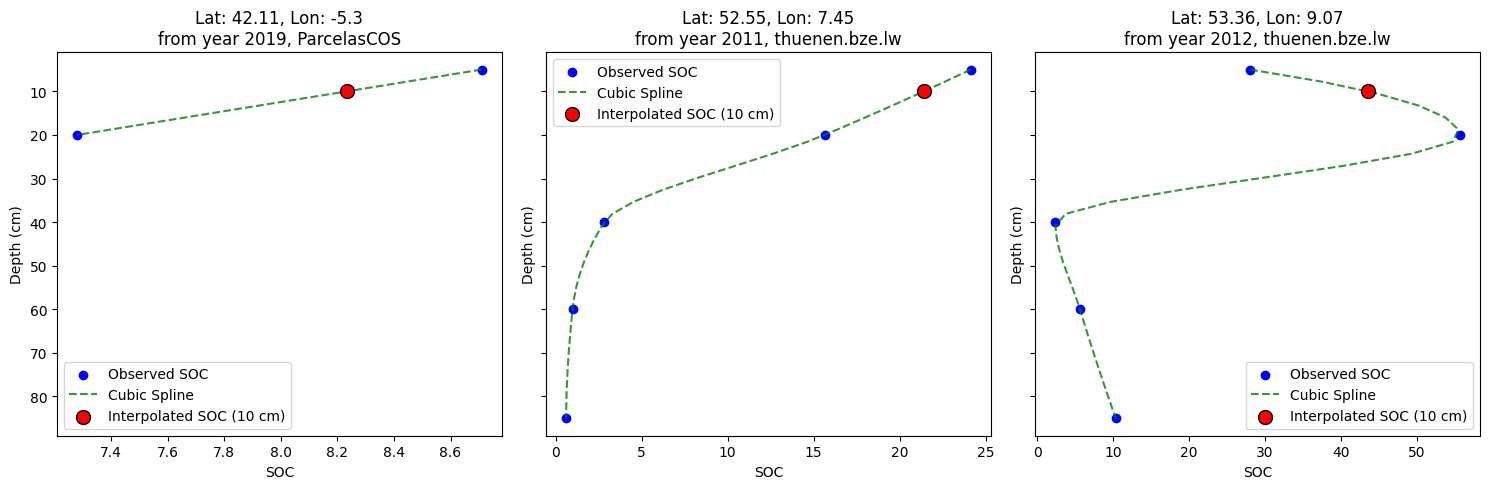

In [10]:
import matplotlib.pyplot as plt
import random
fig, axes = plt.subplots(1, num_examples, figsize=(15, 5), sharey=True)

for ax, ((lat, lon, time, ref), group) in zip(axes, selected_examples.groupby(['lat', 'lon','time','ref'])):
    group = group.sort_values(by='hzn_dep').drop_duplicates(subset=['hzn_dep'])

    pc = PchipInterpolator(group['hzn_dep'], group['soc'])
    depths = np.linspace(min(group['hzn_dep']), max(group['hzn_dep']), 30)
    soc_spline = pc(depths)
    interpolated_soc = pc(10)  

    ax.scatter(group['soc'], group['hzn_dep'], label="Observed SOC", color='blue', zorder=2)
    
    ax.plot(soc_spline, depths, label="Cubic Spline", linestyle='--', color='green', alpha=0.8)

    ax.scatter(interpolated_soc, 10, color='red', s=100, edgecolor='black', label="Interpolated SOC (10 cm)", zorder=3)

    ax.invert_yaxis()  # Depth increases downwards
    ax.set_ylabel("Depth (cm)")  
    ax.set_xlabel("SOC")  
    ax.set_title(f"Lat: {round(lat,2)}, Lon: {round(lon,2)}\nfrom year {time}, {ref}")
    ax.legend()

plt.tight_layout()
plt.show()


### Clean out some columns

In [11]:
dff.columns[0:65]

Index(['time', 'lat', 'lon', 'id', 'clay', 'clay_unit', 'clay_method',
       'bulk.density.tot_unit', 'bulk.density.tot_method', 'bulk.density.tot',
       'coarse.mass_unit', 'coarse.mass_method', 'coarse.mass', 'lc_survey',
       'ref', 'nuts0', 'ph.h2o', 'bulk.density.fe', 'total.n', 'extractable.p',
       'WEB_ID_SQUARE (ID)', 'WEB_ID_PLOT', 'PLOT_TYPE',
       'bulk.density.fe_method', 'bulk.density.fe_unit', 'total.n_unit',
       'total.n_method', 'extractable.p_method', 'extractable.p_unit',
       'ph.h2o_method', 'ph.cacl2_method', 'ph.cacl2', 'extractable.k',
       'extractable.k_method', 'extractable.k_unit', 'cec', 'cec_unit',
       'cec_method', 'sand', 'silt', 'silt_method', 'silt_unit', 'sand_method',
       'sand_unit', 'total.c', 'c/n', 'total.c_method', 'total.c_unit',
       'carbonates', 'ec', 'carbonates_method', 'ec_method', 'ph.h2o_unit',
       'carbonates_unit', 'ec_unit', 'coarse.vol', 'coarse.vol_unit',
       'coarse.vol_method', 'ph.cacl2_unit', 'hzn_

In [12]:
drop_col = ['clay_unit', 'clay_method', 'bulk.density.tot_unit', 'bulk.density.tot_method', 'bulk.density.tot',
       'coarse.mass_unit', 'coarse.mass_method', 'coarse.mass', 'bulk.density.fe', 'extractable.p',
       'WEB_ID_SQUARE (ID)', 'WEB_ID_PLOT', 'PLOT_TYPE',
       'bulk.density.fe_method', 'bulk.density.fe_unit', 'total.n_unit',
       'total.n_method', 'extractable.p_method', 'extractable.p_unit',
       'ph.h2o_method', 'ph.cacl2_method', 'extractable.k',
       'extractable.k_method', 'extractable.k_unit', 'cec', 'cec_unit',
       'cec_method', 'sand', 'silt', 'silt_method', 'silt_unit', 'sand_method',
       'sand_unit', 'total.c', 'c/n', 'total.c_method', 'total.c_unit',
       'carbonates', 'ec', 'carbonates_method', 'ec_method', 'ph.h2o_unit',
       'carbonates_unit', 'ec_unit', 'coarse.vol', 'coarse.vol_unit',
       'coarse.vol_method', 'ph.cacl2_unit', 'ocd', 'ocd_method',
       'soc_qa']

dff = dff.drop(columns=drop_col)
print(dff.shape)

(94248, 418)


### organize covariate features

In [13]:
fix_col = []
covs = dff.columns[13::].tolist()
for icov in covs:
    inum = dff[icov].isna().sum()
    irto = round(inum/len(dff),3)
    
    if irto>0.02:
        print(icov, irto, dff[icov].min(), dff[icov].max())
        fix_col.append(icov)

cropland.extent_glad.interpolate_p_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20240604 0.634 25.0 100.0
b3_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.6 104.0 6050.0
CHELSA_swe_1981-2010_V.2.1 0.657 35.0 28517.0
b12_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.6 43.0 6815.0
b6_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.6 51.0 7486.0
b4_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.6 119.0 6890.0
b2_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.6 57.0 5343.0
b8_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.6 45.0 7494.0
b11_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.6 65.0 8015.0
b7_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.6 54.0 7562.0
b5_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.6 157.0 7170.0
b8a_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.6 39.0 7857.0


In [14]:
fl = 'cropland.extent_glad.interpolate_p_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20240604'
dff.loc[dff[fl].isna(),fl] = 0
dff.loc[dff[fl]>0,fl] = 100
fix_col.remove(fl)

fl = 'CHELSA_swe_1981-2010_V.2.1'
dff = dff.drop(columns=[fl])
fix_col.remove(fl)
covs.remove(fl)

for fl in fix_col:
    dff.loc[dff[fl].isna(),fl] = 0


In [15]:
fix_col = []

for icov in covs:
    inum = dff[icov].isna().sum()
    irto = round(inum / len(dff), 3)
    
    if inum > 0:
        print(icov, irto, inum)
        fix_col.append(icov) 

dff[fix_col] = dff[fix_col].fillna(dff[fix_col].mean())

ndvi_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127 0.001 50
evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0901_YYYY1031_eu_epsg.3035_v20231127 0.001 50
clm_lst_mod11a2.nighttime_p05_1km_s0..0cm_YYYY_v1.2 0.002 145
ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127 0.001 50
evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0301_YYYY0430_eu_epsg.3035_v20231127 0.001 50
wv_mcd19a2v061.seasconv.m.yearly_p25_1km_s_YYYY0101_YYYY1231_go_epsg.4326_v20230619 0.0 2
blue_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127 0.001 50
swir1_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127 0.001 50
wv_mcd19a2v061.seasconv.m.yearly_p50_1km_s_YYYY0101_YYYY1231_go_epsg.4326_v20230619 0.0 2
nos_glad.landsat.ard2.seasconv_m_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127 0.001 50
bare.soil_mcd43a4.fc_m_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616 0.003 266
photo

In [16]:
# double check the nan
for icov in covs:
    inum = dff[icov].isna().sum()
    irto = round(inum / len(dff), 3)
    
    if inum > 0:
        print(icov, irto, inum)
        fix_col.append(icov) 

In [17]:
dummies = pd.get_dummies(dff['soilsuite_mask'], prefix='soilsuite')
dummies = dummies.rename(columns={'soilsuite_1.0':'soilsuite_bare', 'soilsuite_2.0':'soilsuite_veg','soilsuite_3.0':'soilsuite_other'})
dff = pd.concat([dff, dummies], axis=1)
dff = dff.drop(columns=['soilsuite_mask'])
print(dff.shape)

(94248, 420)


## check duplicates

In [18]:
dff.loc[dff.duplicated()]

,time,lat,lon,id,clay,lc_survey,ref,nuts0,ph.h2o,total.n,...,min.curv.bareearth_ensemble_m_30m_s_20000101_20221231_eu_epsg.3035_v20240424,CHELSA_bio1_1981-2010_V.2.1,lithology.105.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530,fapar_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231218,ls.factor.bareearth_ensemble_m_480m_s_20000101_20221231_eu_epsg.3035_v20240501,type,soilsuite_bare,soilsuite_1.6080832481384277,soilsuite_veg,soilsuite_other


## save file

In [19]:
dff.to_parquet('./material/soc.topsoil_organized.pq')

In [20]:
dff['lc_survey'].value_counts()

lc_survey
cropland                    39396
woodland                    26613
grassland                   22959
bare land & lichens/moss     2505
shrubland                    2049
water areas & wetland         291
others                        251
artificial land               184
Name: count, dtype: int64

## split data

In [36]:
import geopandas as gpd
eu_tile = gpd.read_file('/home/xuemeng/work_xuemeng/soc/data/000_tiles.correct_epsg.3035.gpkg')

In [37]:
gdf = gpd.GeoDataFrame(dff, geometry=gpd.points_from_xy(dff.lon, dff.lat))
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(eu_tile.crs)

joined_gdf = gpd.sjoin(gdf, eu_tile, how="left", op='within')
joined_gdf = joined_gdf.drop(columns=['geometry','index_right'])
joined_gdf = joined_gdf.rename(columns={'id_right':'tile_id','id_left':'id'})
print(joined_gdf.shape)
print(dff.shape)
joined_gdf.to_parquet('./material/soc.topsoil_organized.pq')


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


(94248, 421)
(94248, 420)
